# Performance comparison of 2D finite difference wave propagation GPU implementations
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](https://www.ausargeo.com))*

I [previously](https://github.com/ar4/wave_2d_fd_perf/blob/master/notebooks/wave_2d_fd_perf.ipynb) investigated the performance of 2D finite difference wave propagation for various CPU implementations. This time I am trying it out on a GPU. I am particularly interested in how [Numba](https://numba.pydata.org) and [PyTorch](https://pytorch.org/), two packages that allow you to write Python code that gets executed on a GPU, compare with [CUDA](https://developer.nvidia.com/cuda-gpus).

I unfortunately wasn't very impressed when I tried Numba for [1D wave propagation on the CPU](https://github.com/ar4/wave_1d_fd_perf/blob/master/notebooks/wave_1d_fd_perf.ipynb), but perhaps it will work better on a GPU. I haven't used PyTorch in any of my previous comparisons (I used to use [TensorFlow](https://www.tensorflow.org/), and tried that for [1D wave propagation on the CPU](https://github.com/ar4/wave_1d_fd_tf/blob/master/notebooks/wave_1d_fd_tf.ipynb), but have since made the switch). It is primarily intended for deep learning, but since finite difference wave propagation uses [similar types of computations](https://arxiv.org/abs/1801.07232), especially convolutions, it might give good performance for that as well.

It would be great if Numba or PyTorch worked well, as they are much easier to work with than CUDA. CUDA must be compiled using `nvcc`, which makes distributing your Python package with an easy install mechanism more difficult. As you write your code in Python when using Numba and PyTorch, this problem doesn't arise (mostly - Numba and PyTorch can be a little difficult to install themselves). PyTorch, in particular, also takes away most of the complications of CUDA. You don't have to worry about whether to use global, shared, texture, or constant memory, or how many threads to have in each block, as PyTorch handles all of the details. Of course this also means that you have fewer nobs to twist to optimize performance, so we have to hope that PyTorch does a good job on its own.

I use a 4th order in space, two time step finite difference propagator with the scalar wave equation. For simplicity, I don't use any absorbing boundary conditions. I run the code on an Nvidia Tesla K80 GPU, with CUDA 8, CuDNN 7.1.4, PyTorch 0.4.0 and Numba 0.38.1.

## Implementations

### [Pytorch1](https://github.com/ar4/wave_2d_fd_perf_gpu/blob/master/wave_2d_fd_perf_gpu/pytorch.py#L31)
This straightforward implementation only requires a few lines of code, and looks similar to a simple pure-Python version. I implement the Laplacian calculation using the 2D convolution function that comes with PyTorch, which uses [CuDNN](https://developer.nvidia.com/cudnn).
 

### [Pytorch2](https://github.com/ar4/wave_2d_fd_perf_gpu/blob/master/wave_2d_fd_perf_gpu/pytorch.py#L63)
Instead of using the built-in CuDNN convolution to calculate the Laplacian, this version uses a manual implementation. The edges of the domain are handled automatically in Pytorch1 as CuDNN's convolution applies padding before calculating the convolution, but in this version I have to manually pad the edges of the domain. The result is quite a bit uglier.

### [Numba1](https://github.com/ar4/wave_2d_fd_perf_gpu/blob/master/wave_2d_fd_perf_gpu/numba.py)
Numba is closer to CUDA than PyTorch is. You have to deal with things like threads, blocks, and kernels yourself. This includes thinking about synchronization. As it is not possible to synchronize across blocks (at least on the GPU I am targeting - it's not impossible on some newer ones), each time step needs to be performed using a separate kernel. It is possible to do all of the computations for each time step in a single kernel, as I do in one of the CUDA implementations below, but for simplicity here I split "the evolution equation" and "adding the source term" into two separate kernels. Numba doesn't have a built-in convolution function that can run on a GPU, as far as I know, so I use a manual implementation.

### [Cuda1](https://github.com/ar4/wave_2d_fd_perf_gpu/blob/master/wave_2d_fd_perf_gpu/vcuda1.cu)
My simplest CUDA implementation is essentially Numba1 converted to pure CUDA. I use constant memory to store the finite difference coefficients, but otherwise don't do anything fancy.

### [Cuda2](https://github.com/ar4/wave_2d_fd_perf_gpu/blob/master/wave_2d_fd_perf_gpu/vcuda2.cu)
Instead of a manual convolution implementation, this version uses CuDNN, like Pytorch1.

### [Cuda3](https://github.com/ar4/wave_2d_fd_perf_gpu/blob/master/wave_2d_fd_perf_gpu/vcuda3.cu)
This version is the same as Cuda1, but loads blocks of the wavefield into shared memory for the Laplacian calculation. As finite difference wave propagation is usually a memory-bound computation, this should hopefully improve performance by eliminating a few global memory accesses.

### [Cuda4](https://github.com/ar4/wave_2d_fd_perf_gpu/blob/master/wave_2d_fd_perf_gpu/vcuda4.cu)
GPUs, particularly old ones, are sensitive about memory access alignment. Ideally, each warp of threads should load a contiguous block of memory starting on a nicely aligned boundary. The GPU I am targeting is fairly new, so this isn't as much of a concern, but it doesn't take a lot of effort to be a little careful about it. This version is the same as Cuda1 except that I use `cudaMallocPitch` to allocate GPU memory, and the necessary small changes to access such memory. Doing this may add a little padding to the end of each row of the allocated arrays so that each row begins on an alignment boundary.

### [Cuda5](https://github.com/ar4/wave_2d_fd_perf_gpu/blob/master/wave_2d_fd_perf_gpu/vcuda5.cu)
The only change from Cuda1 in this implementation is that I merge the evolution equation and source term injection into a single kernel. This involves having each thread run through the source terms to check if the source is located in their cell. This halves the number of kernel launches.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wave_2d_fd_perf_gpu.run_timing import (run_timing_num_steps, run_timing_model_size)

tns = run_timing_num_steps(num_repeat=3, model_size=400)
tms = run_timing_model_size(num_repeat=3, num_step=5)

## Results

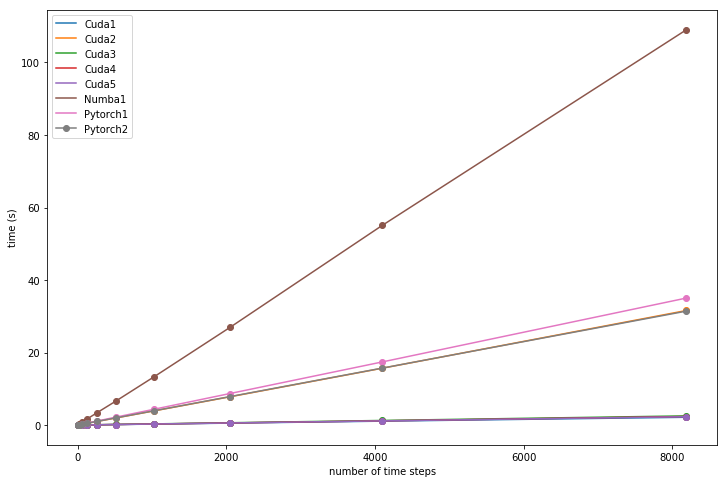

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
vs = tns['version'].unique()
vs.sort()
for version in vs:
    tns[tns['version']==version].plot(x='num_step', y='time', ax=ax, label=version, style='o-')
plt.ylabel('time (s)');
plt.xlabel('number of time steps');

It's hard to see it in the plot, but Cuda2 overlaps Pytorch2.

The results are unfortunately not really what I was hoping for: Numba and PyTorch are several times slower than most of the CUDA implementations. There are a few things I could try that might improve their performance a bit, but they are so much slower than CUDA that I don't think it is worth it.

Surprisingly, using CuDNN seems to be slower than manually calculating the Laplacian: Pytorch1 is slower than Pytorch2, and Cuda2 (the only CUDA version that uses CuDNN) is significantly slower than the other CUDA implementations.

Let's zoom-in to the origin to see if the story is different when we only want to advance by a small number of time steps.

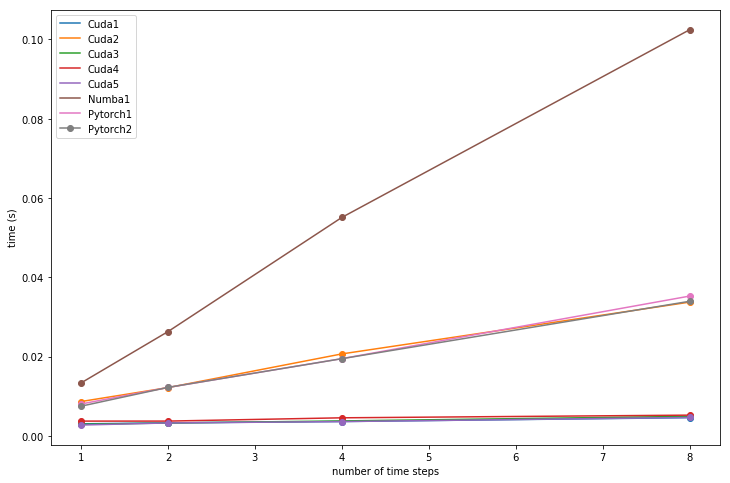

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
vs = tns['version'].unique()
vs.sort()
for version in vs:
    tns[(tns['version']==version)&(tns['num_step']<10)].plot(x='num_step', y='time', ax=ax, label=version, style='o-')
plt.ylabel('time (s)');
plt.xlabel('number of time steps');

The situation seems to be the same even for a small number of time steps.

Keeping the number of time steps fixed while the number of cells in the model changes gives the result below.

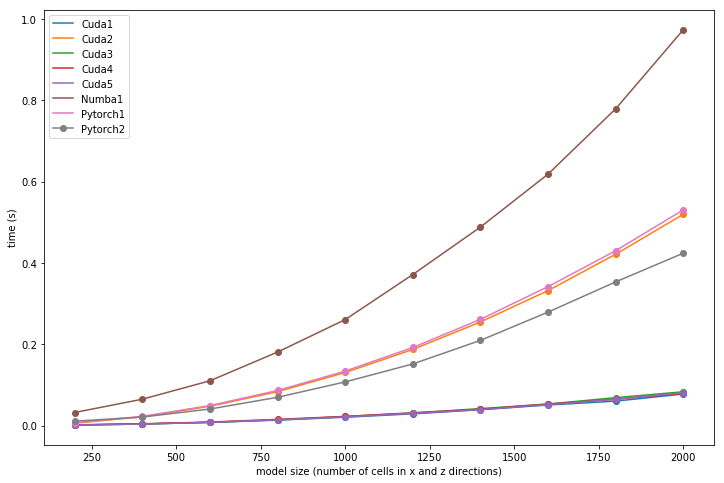

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
vs = tms['version'].unique()
vs.sort()
for version in vs:
    tms[tms['version']==version].plot(x='model_size', y='time', ax=ax, label=version, style='o-')
plt.ylabel('time (s)');
plt.xlabel('model size (number of cells in x and z directions)');

This time Cuda2 is closer to Pytorch1, but otherwise everything is the same.

When plotted with the other implementations, the CUDA versions (except Cuda2) are indistinguishable. Let's take a closer look at them to see if any of the optimizations I tried were effective.

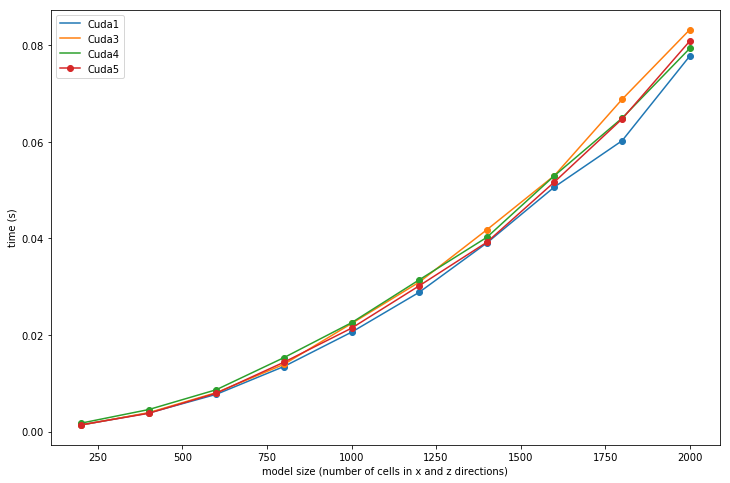

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
vs = ['Cuda1', 'Cuda3', 'Cuda4', 'Cuda5']
for version in vs:
    tms[tms['version']==version].plot(x='model_size', y='time', ax=ax, label=version, style='o-')
plt.ylabel('time (s)');
plt.xlabel('model size (number of cells in x and z directions)');

They really are very similar, and in fact the original version, Cuda1, is the fastest. This suggests that performance is limited by some factor other than the ones I tried to optimize.


## Conclusion
Numba and PyTorch result in pretty code but disappointing performance. If you are using a GPU for your wave propagation code, you probably want it to run fast, and it seems that achieving that probably still requires CUDA.